# Pincode-Level Analysis of High-Risk States for Aadhaar Biometric Completion

This notebook analyzes biometric completion rates at the pincode level for seven high-risk states in India. By examining granular geographic and temporal patterns, it identifies critical pincodes and districts requiring immediate intervention to improve biometric data collection and enrollment completion.

## 1. Import Libraries and Configure Visualization

Import essential libraries for data analysis, visualization, and statistical calculations. Configure matplotlib for consistent figure sizing and visualization quality.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

plt.rcParams["figure.figsize"] = (10, 5)

## 2. Define Paths and Risk States Configuration

Set up file paths for data directories, define the list of high-risk states for focused analysis, and create an output directory for saving results and visualizations.

In [2]:
DATA_DIR_BIO    = "api_data_aadhar_biometric"
DATA_DIR_ENROLL = "api_data_aadhar_enrolment"

RISK_STATES = [
    "assam",
    "dadra and nagar haveli and daman and diu",
    "goa",
    "ladakh",
    "meghalaya",
    "mizoram",
    "sikkim"
]

OUTPUT_DIR = "risk_state_pincode_analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 3. Load Data from Multiple CSV Files

Load biometric and enrollment data from CSV files in the respective folders and concatenate them into unified DataFrames. Display the shape of loaded datasets to verify data integrity.

In [3]:
def load_folder(folder_path):
    dfs = []
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            dfs.append(pd.read_csv(os.path.join(folder_path, file)))
    return pd.concat(dfs, ignore_index=True)

bio_df    = load_folder(DATA_DIR_BIO)
enroll_df = load_folder(DATA_DIR_ENROLL)

print("Loaded:")
print("Biometric:", bio_df.shape)
print("Enrollment:", enroll_df.shape)

Loaded:
Biometric: (1861108, 6)
Enrollment: (1006029, 7)


## 4. Data Preprocessing and Normalization

Clean column names, normalize state names to consistent lowercase format with corrections for spelling variations, and parse dates to extract monthly periods for temporal analysis.

In [4]:
def preprocess(df):
    df.columns = df.columns.str.strip()

    df["state"] = (
        df["state"]
        .str.strip()
        .str.lower()
        .replace({
            "orissa": "odisha",
            "tamilnadu": "tamil nadu",
            "westbengal": "west bengal"
        })
    )

    df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")
    df["month"] = df["date"].dt.to_period("M")

    return df

bio_df    = preprocess(bio_df)
enroll_df = preprocess(enroll_df)

## 5. Filter Data for High-Risk States Only

Filter both biometric and enrollment datasets to include only records from the seven identified high-risk states, reducing dataset size for focused analysis.

In [5]:
bio_df    = bio_df[bio_df["state"].isin(RISK_STATES)]
enroll_df = enroll_df[enroll_df["state"].isin(RISK_STATES)]

print("After filtering risk states:")
print("Biometric:", bio_df.shape)
print("Enrollment:", enroll_df.shape)


After filtering risk states:
Biometric: (63955, 7)
Enrollment: (40036, 8)


## 6. Aggregate Data by Month, State, District, and Pincode

Group biometric and enrollment data at the finest granular level (pincode-level) aggregated by month. This enables analysis of completion rates at the locality level, which is crucial for identifying specific geographic problem areas.

In [20]:
bio_agg = (
    bio_df
    .groupby(["month", "state", "district", "pincode"], as_index=False)
    .sum(numeric_only=True)
)
enroll_agg = (
    enroll_df
    .groupby(["month", "state", "district", "pincode"], as_index=False)
    .sum(numeric_only=True)
)


# Rename for clarity
bio_agg = bio_agg.rename(columns={"bio_age_17_": "bio_18p"})
enroll_agg = enroll_agg.rename(columns={"age_18_greater": "enroll_18p"})

## 7. Merge Datasets and Calculate Biometric Completion Rates

Merge biometric and enrollment aggregates on month, state, and pincode. Calculate the biometric completion rate as the ratio of biometric records to enrollments, handling infinite values and missing data.

In [21]:
df = bio_agg.merge(
    enroll_agg[["month", "state", "pincode", "enroll_18p"]],
    on=["month", "state", "pincode"],
    how="left"
)

df["enroll_18p"] = df["enroll_18p"].replace(0, np.nan)
df["bio_rate_18p"] = df["bio_18p"] / df["enroll_18p"]

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=["bio_rate_18p"], inplace=True)


## 8. Identify Anomalies in Biometric Completion Rates

Define anomalies as records where biometric completion rates fall below the 5th percentile (low-performance pincodes) or equal zero (complete collection failure). Count total anomalies for severity assessment.

In [22]:
LOW_THRESHOLD = df["bio_rate_18p"].quantile(0.05)

df["low_anomaly"]  = df["bio_rate_18p"] < LOW_THRESHOLD
df["zero_anomaly"] = df["bio_rate_18p"] == 0

anomalies = df[df["low_anomaly"] | df["zero_anomaly"]]

print("Total anomalies:", anomalies.shape[0])

Total anomalies: 153


## 9. Create Pincode-Level Summary Statistics

Aggregate data at the pincode level across all months to create summary metrics: average biometric rate, count of anomalies, count of zero-rate months, and total months observed. Sort by state and average rate.

In [23]:
pincode_summary = (
    df.groupby(["state", "pincode"], as_index=False)
      .agg(
          avg_bio_rate=("bio_rate_18p", "mean"),
          anomaly_count=("low_anomaly", "sum"),
          zero_count=("zero_anomaly", "sum"),
          months_observed=("bio_rate_18p", "count")
      )
      .sort_values(["state", "avg_bio_rate"])
)


## 10. Calculate Risk Scores for Pincodes

Compute risk ratios and a composite risk score combining three factors:
- **Zero Ratio** (50% weight): Proportion of months with zero biometric collection
- **Anomaly Ratio** (30% weight): Proportion of months with anomalously low rates
- **Inverse Avg Rate** (20% weight): Penalty for low average completion rates

This composite score prioritizes pincodes with systemic data collection failures.

In [24]:
pincode_summary["zero_ratio"] = (
    pincode_summary["zero_count"] / pincode_summary["months_observed"]
)

pincode_summary["anomaly_ratio"] = (
    pincode_summary["anomaly_count"] / pincode_summary["months_observed"]
)

# Composite risk score
pincode_summary["risk_score"] = (
    0.5 * pincode_summary["zero_ratio"] +
    0.3 * pincode_summary["anomaly_ratio"] +
    0.2 * (1 / (1 + pincode_summary["avg_bio_rate"]))
)


## 11. Identify Top 10 Critical Pincodes Per State

Extract the top 10 highest-risk pincodes for each state based on composite risk scores. These represent the most critical locations requiring urgent intervention for improving biometric completion.

In [25]:
CRITICAL_PINCODES = (
    pincode_summary
    .sort_values("risk_score", ascending=False)
    .groupby("state")
    .head(10)
)


## 12. Display Column Names for Verification

Print all column names from the original datasets to verify data availability and structure, ensuring all required columns are present for analysis.

In [26]:
print(bio_df.columns)
print(enroll_df.columns)


Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_',
       'month'],
      dtype='object')
Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
       'age_18_greater', 'month'],
      dtype='object')


## 13. Create District-Level Summary Statistics

Aggregate biometric completion data at the district level to identify district-wide trends and challenges. Calculate average biometric rates and frequency of anomalous months to assess district-level performance and risk factors.

In [28]:
district_summary = (
    df.groupby(["state", "district"], as_index=False)
      .agg(
          avg_bio_rate=("bio_rate_18p", "mean"),
          anomaly_months=("low_anomaly", "sum"),
          zero_months=("zero_anomaly", "sum"),
          total_months=("bio_rate_18p", "count")
      )
)

district_summary["zero_ratio"] = district_summary["zero_months"] / district_summary["total_months"]


## 14. Dual Histogram Visualization: Zero Ratio and Non-Zero Rates by State

Create paired histograms for each state showing:
1. **Left Panel**: Distribution of zero-capture ratios across pincodes (how often biometric collection completely fails)
2. **Right Panel**: Distribution of non-zero biometric rates using logarithmic scale (for pincodes with at least some data collection)

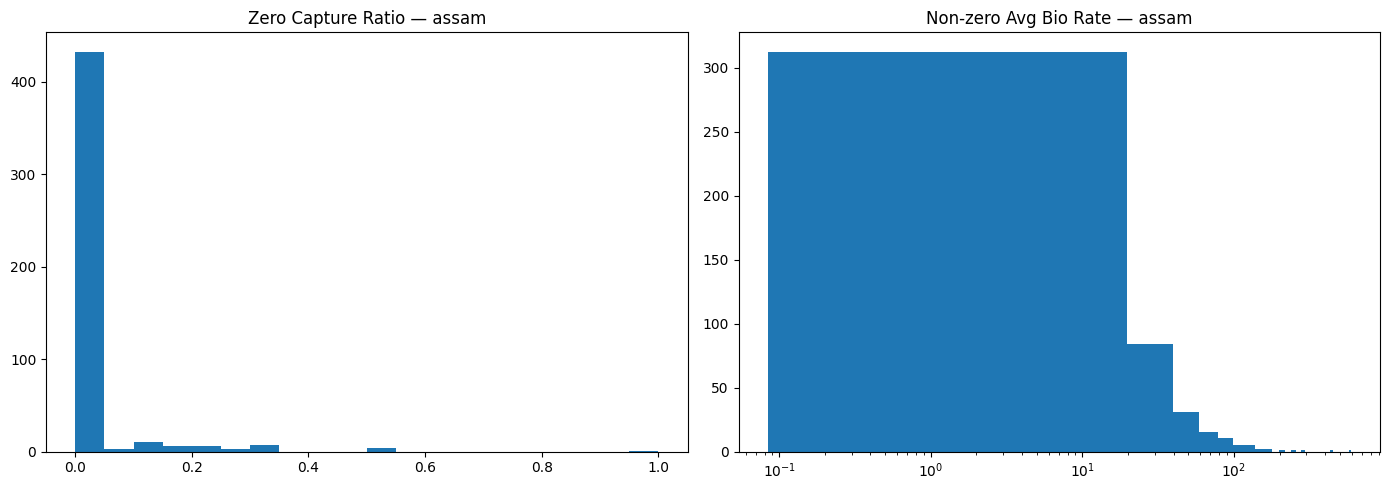

<Figure size 1000x500 with 0 Axes>

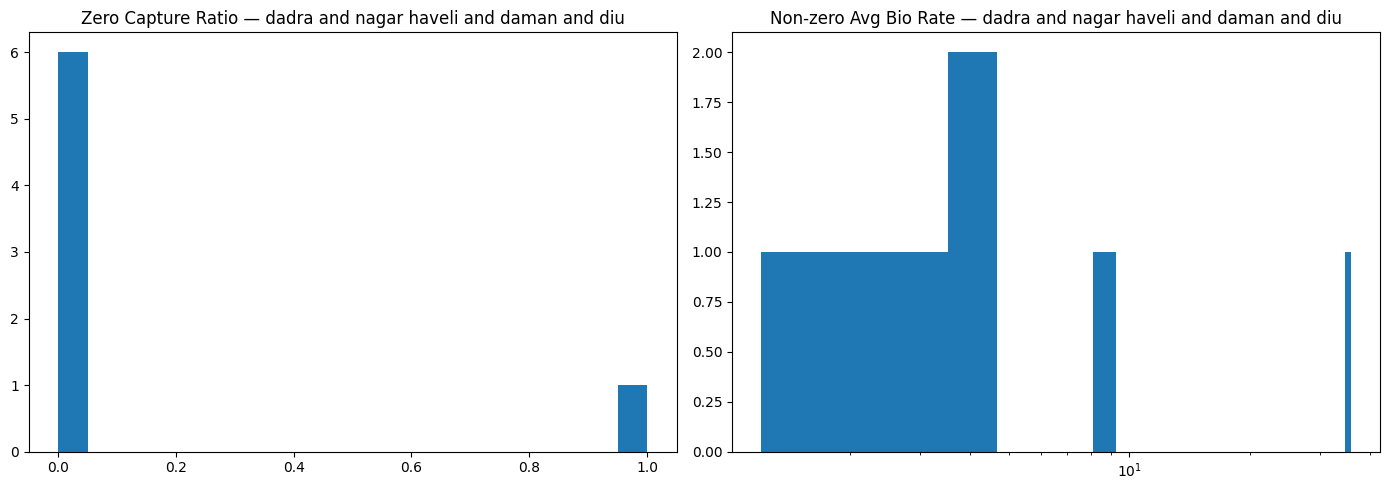

<Figure size 1000x500 with 0 Axes>

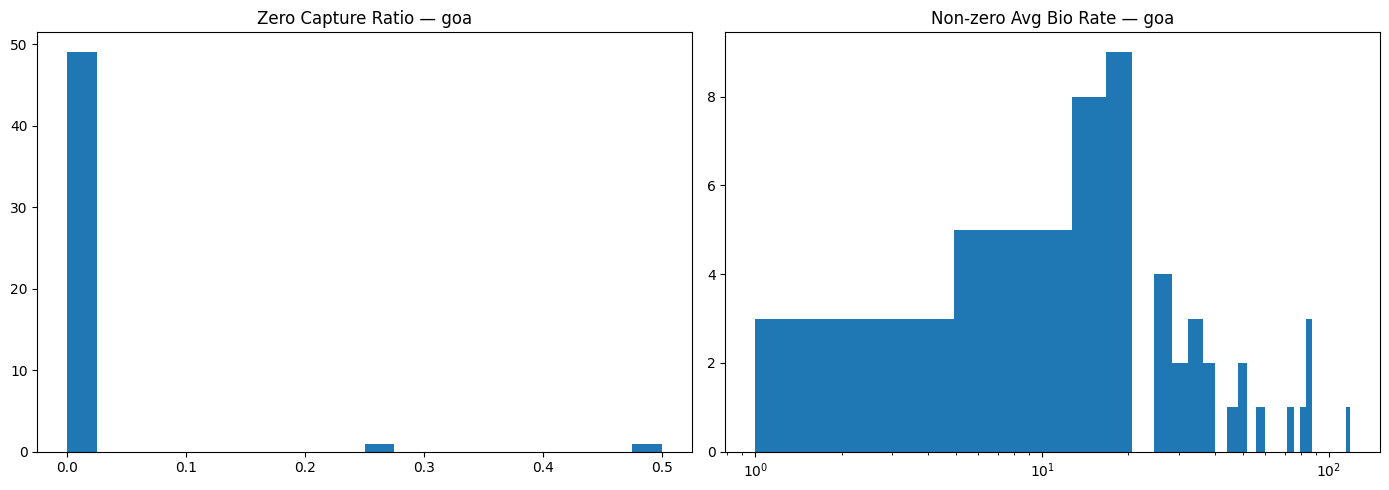

<Figure size 1000x500 with 0 Axes>

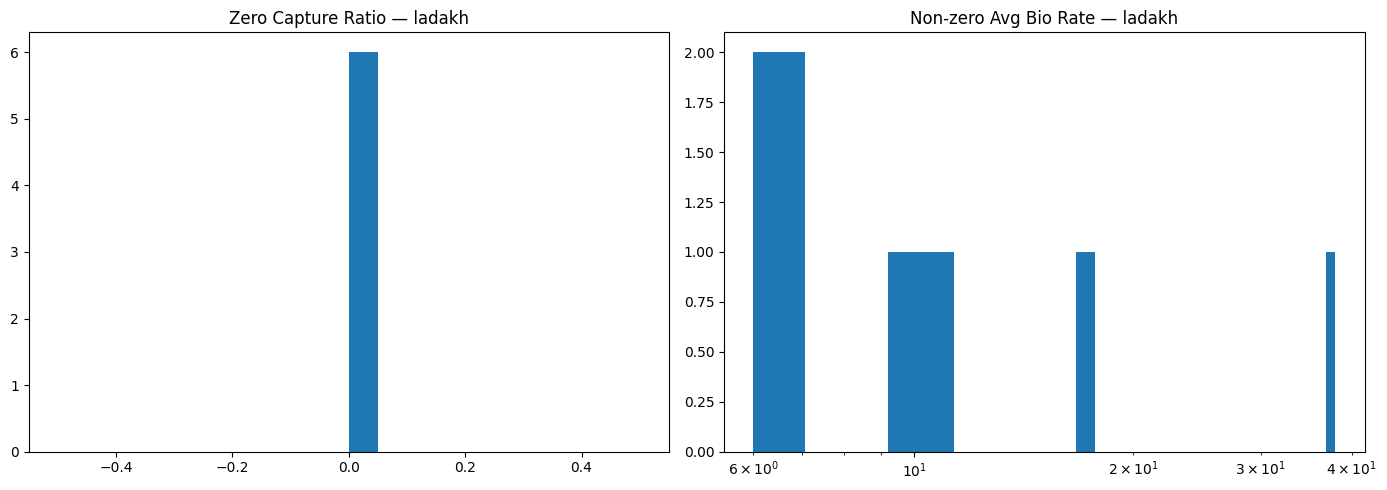

<Figure size 1000x500 with 0 Axes>

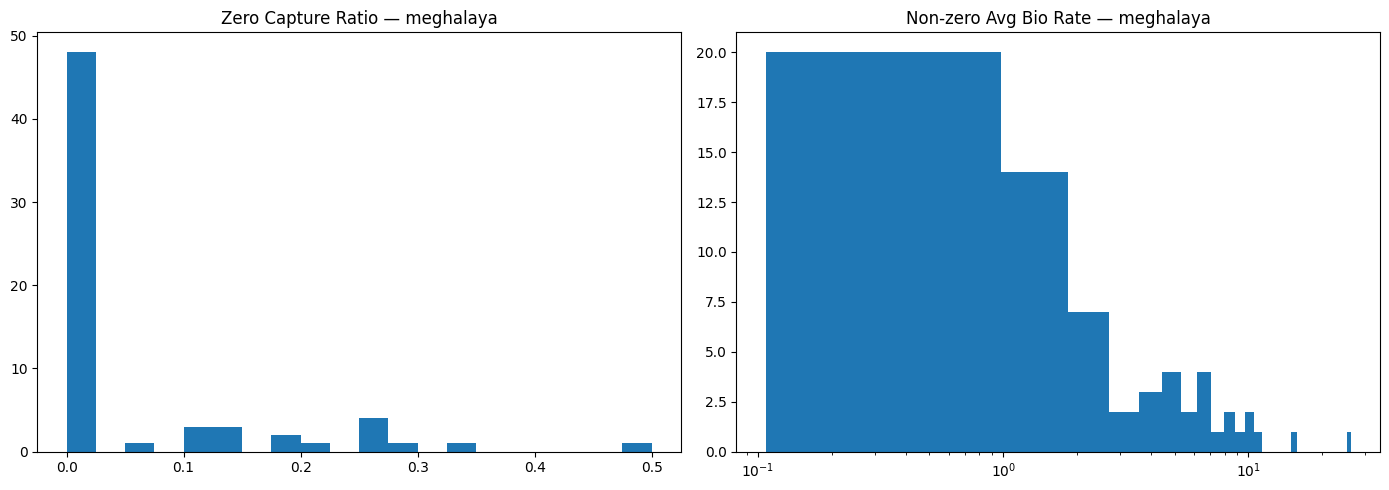

<Figure size 1000x500 with 0 Axes>

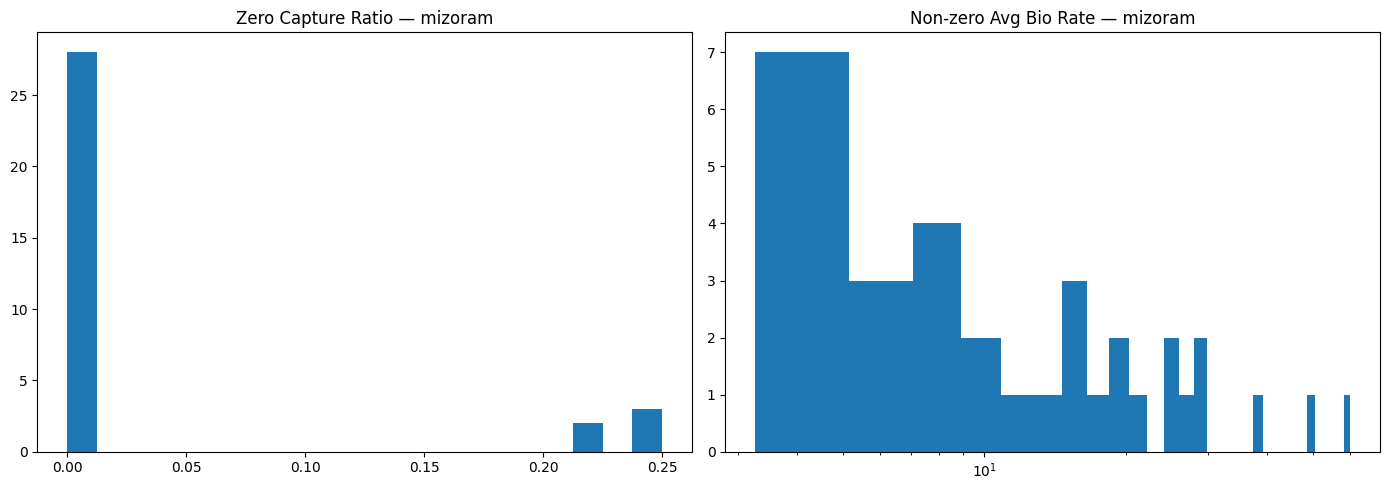

<Figure size 1000x500 with 0 Axes>

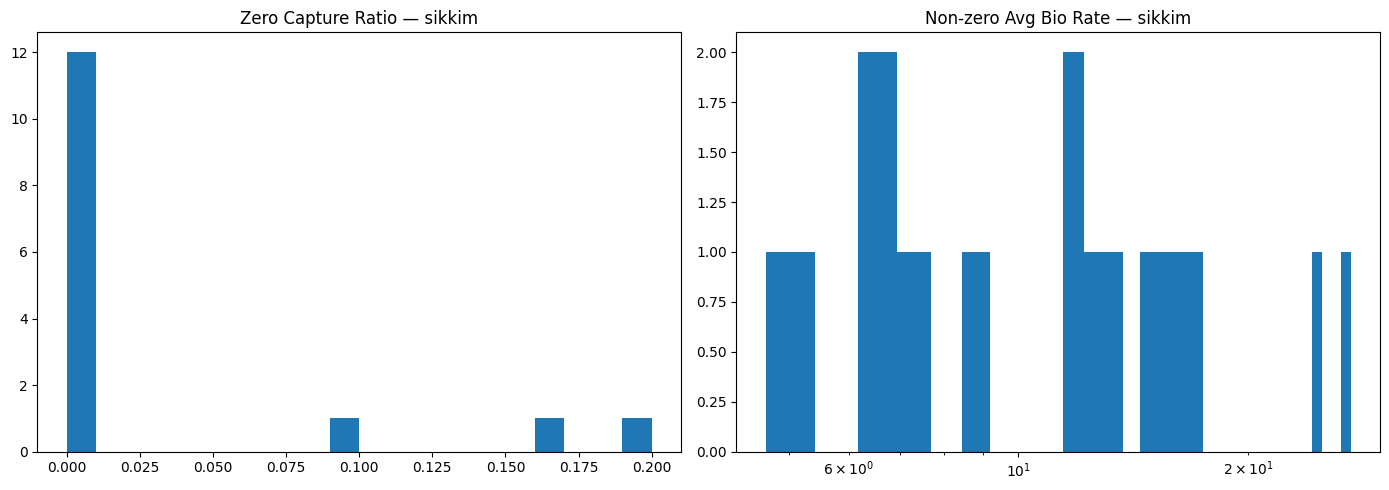

<Figure size 1000x500 with 0 Axes>

In [40]:
for state in RISK_STATES:
    state_df = pincode_summary[pincode_summary["state"] == state]

    if state_df.empty:
        continue

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Zero dominance
    axes[0].hist(state_df["zero_ratio"], bins=20)
    axes[0].set_title(f"Zero Capture Ratio — {state}")

    # Severity (non-zero average bio rate)
    axes[1].hist(state_df[state_df["avg_bio_rate"] > 0]["avg_bio_rate"], bins=30)
    axes[1].set_xscale("log")
    axes[1].set_title(f"Non-zero Avg Bio Rate — {state}")

    plt.tight_layout()
    plt.show()
    plt.savefig(f"{OUTPUT_DIR}/{state}_pincode_histograms.png", dpi=300)


### Graph Interpretation: State-Level Pincode Histograms

**Left Panel - Zero Capture Ratio Distribution**:
- X-axis: Proportion of months (0 to 1) where biometric collection was completely absent
- Y-axis: Number of pincodes with that zero-ratio
- High bars near 0: Many pincodes with consistent biometric data collection
- High bars near 1: Many pincodes with complete data collection failures
- Interpretation: A distribution skewed toward 1 indicates severe systemic issues requiring immediate operational intervention

**Right Panel - Non-Zero Biometric Rate Distribution (Log Scale)**:
- X-axis (log scale): Average biometric completion rate for pincodes with non-zero rates
- Y-axis: Number of pincodes with that rate
- Log scale reveals the wide range from very low rates (near 1) to high rates (100+)
- Wide spread: Indicates high variation in implementation capacity and infrastructure readiness across pincodes
- Sharp peak at lower values: Suggests majority of pincodes struggle with completion rates even when data collection occurs

### Graph Interpretation: State-Level Pincode Histograms

**Left Panel - Zero Capture Ratio Distribution**:
- X-axis: Proportion of months (0 to 1) where biometric collection was completely absent
- Y-axis: Number of pincodes with that zero-ratio
- High bars near 0: Many pincodes with consistent biometric data collection
- High bars near 1: Many pincodes with complete data collection failures
- Interpretation: A distribution skewed toward 1 indicates severe systemic issues requiring immediate operational intervention

**Right Panel - Non-Zero Biometric Rate Distribution (Log Scale)**:
- X-axis (log scale): Average biometric completion rate for pincodes with non-zero rates
- Y-axis: Number of pincodes with that rate
- Log scale reveals the wide range from very low rates (near 1) to high rates (100+)
- Wide spread: Indicates high variation in implementation capacity and infrastructure readiness across pincodes
- Sharp peak at lower values: Suggests majority of pincodes struggle with completion rates even when data collection occurs

## 15. Pincode-Level Average Biometric Rate Distribution by State

Visualize the distribution of average biometric completion rates across all pincodes within each state using histograms with kernel density estimation. Create one visualization per state.

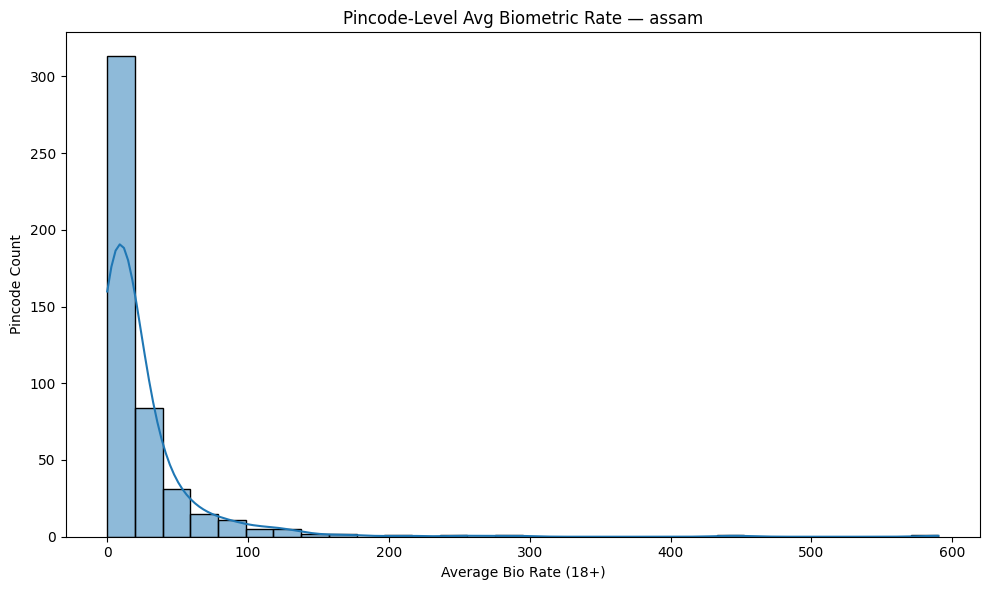

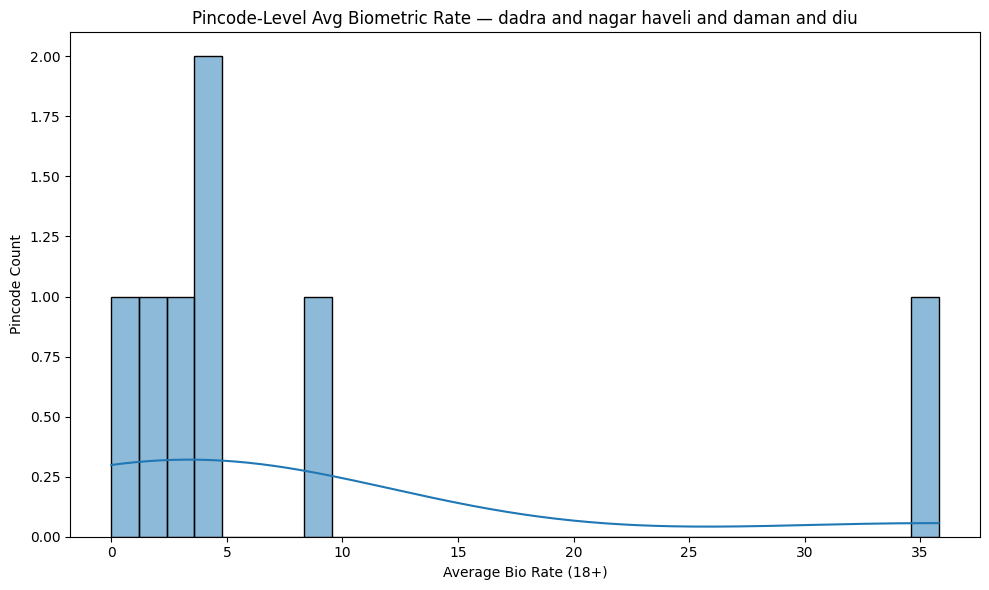

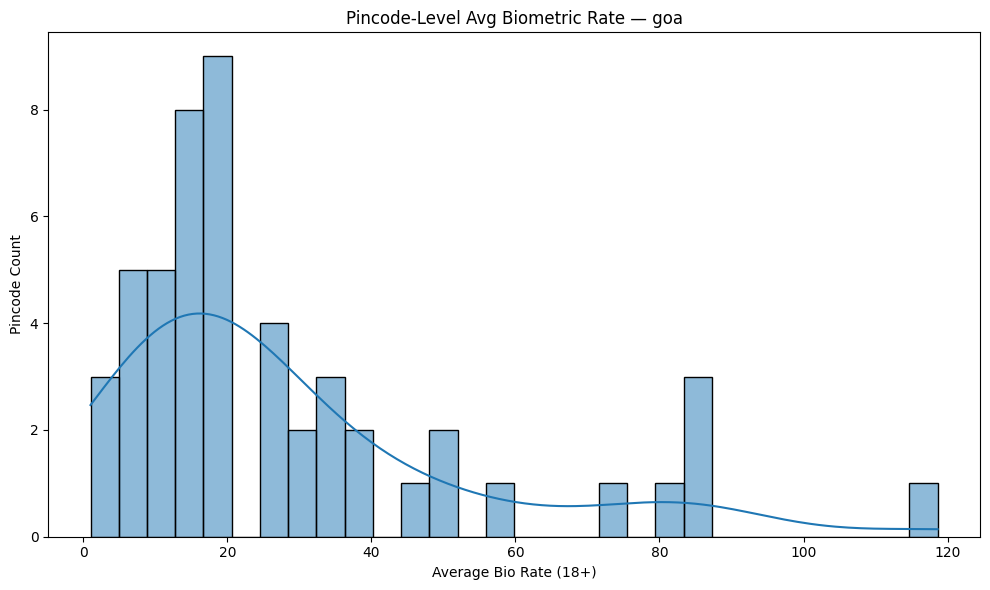

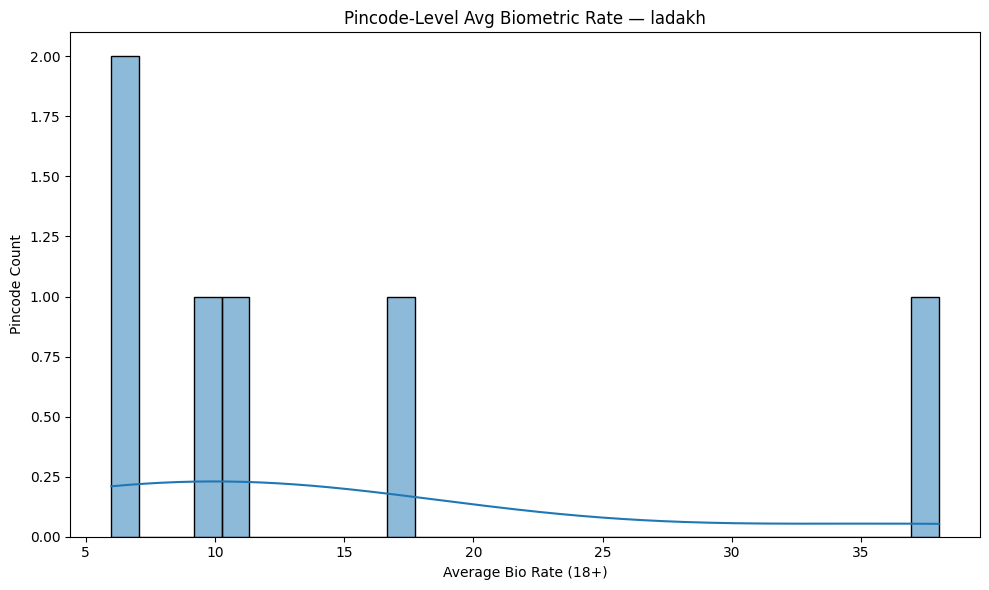

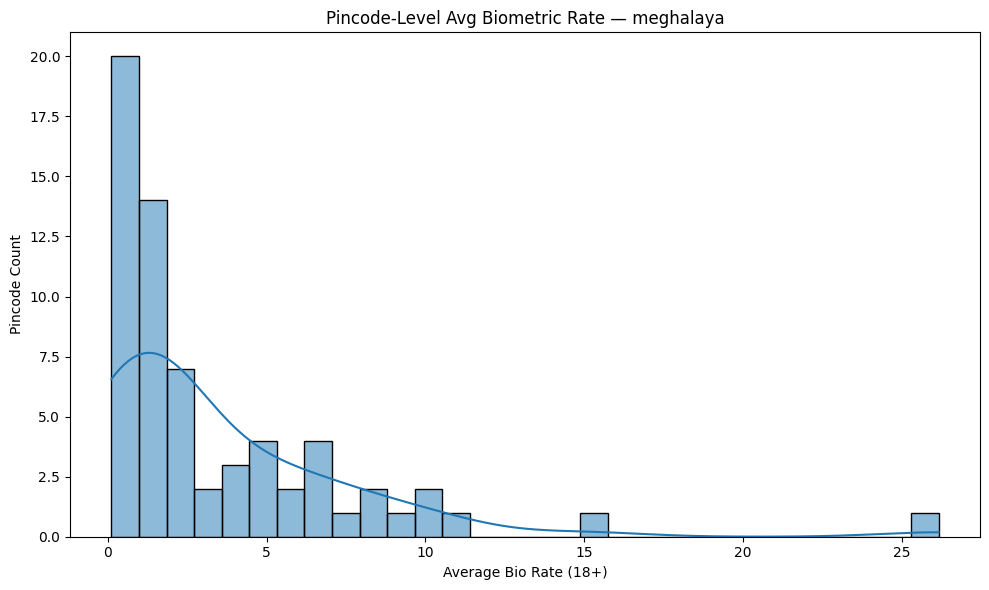

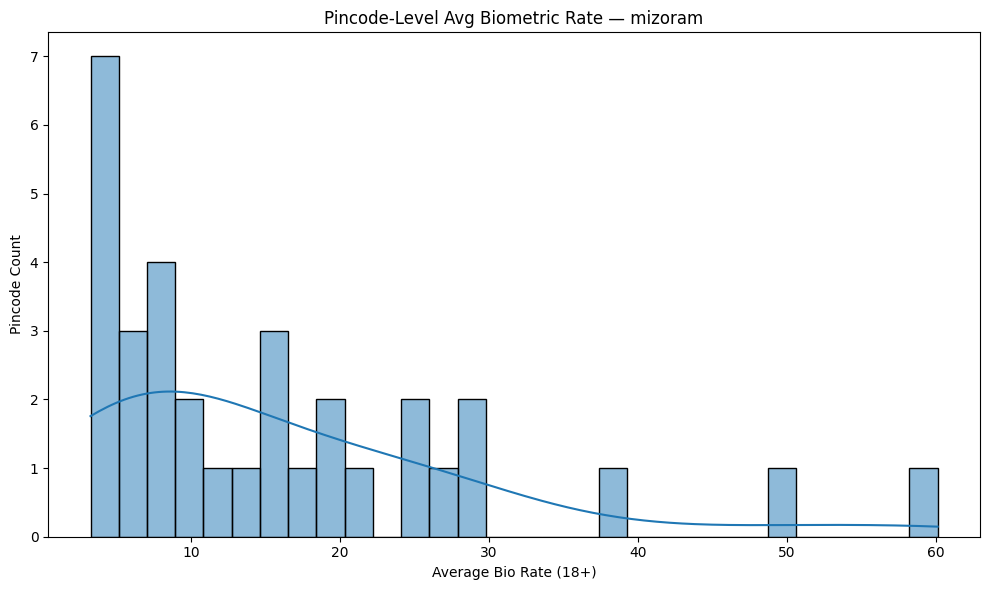

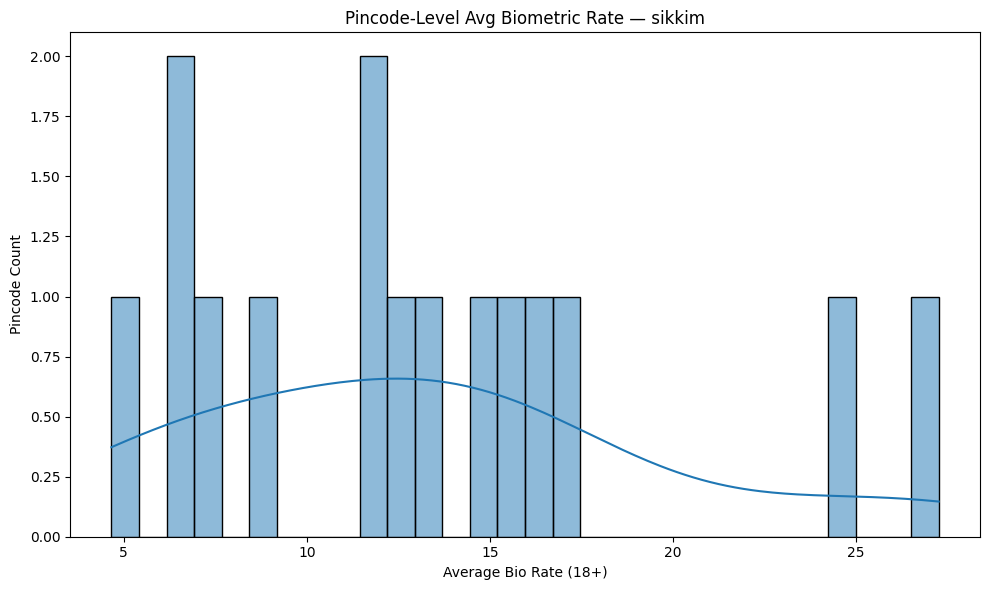

In [31]:
for state in RISK_STATES:
    state_df = pincode_summary[pincode_summary["state"] == state]

    if state_df.empty:
        continue

    plt.figure(figsize=(10, 6))
    sns.histplot(state_df["avg_bio_rate"], bins=30, kde=True)
    plt.title(f"Pincode-Level Avg Biometric Rate — {state}")
    plt.xlabel("Average Bio Rate (18+)")
    plt.ylabel("Pincode Count")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/{state}_pincode_distribution.png", dpi=300)
    #plt.close()

### Graph Interpretation: Pincode-Level Distribution with KDE

**Histogram Bars**: Show the count of pincodes at each biometric completion rate level
- Multiple bars indicate variability in pincode-level performance
- Concentration at lower values suggests widespread implementation challenges

**KDE Curve**: Smooth kernel density estimate overlaid on histogram
- Reveals the underlying probability distribution of pincode performance
- Single peak: Consistent implementation across pincodes
- Multiple peaks: Distinct performance clusters (e.g., well-performing vs. struggling pincodes)
- Right-skewed: Most pincodes have lower rates, few perform exceptionally well

**Key Metrics from This View**:
- **Modal rate**: The most common completion rate level identifies typical pincode performance
- **Spread**: Wide distribution indicates high heterogeneity in operational capacity
- **Tails**: Left tail shows how many critical pincodes are severely underperforming

## 16. Data Type Check for Anomalies Dataset

Verify the data type of the month column in the anomalies DataFrame to ensure it's compatible with time-series visualization operations.

In [35]:
# Make a copy to avoid SettingWithCopyWarning
anomalies = anomalies.copy()

# If 'month' is already datetime, just leave it as is
# No need for .dt.to_timestamp()
# Check type
print(anomalies["month"].dtype)


datetime64[ns]


## 17. Time-Series Anomalies Scatter Plot: Temporal and Spatial Analysis

Create a scatter plot showing all pincode-month anomalies over time, with logarithmic y-axis scale to reveal both near-zero and low-rate anomalies. Color-code by state to identify geographic patterns.

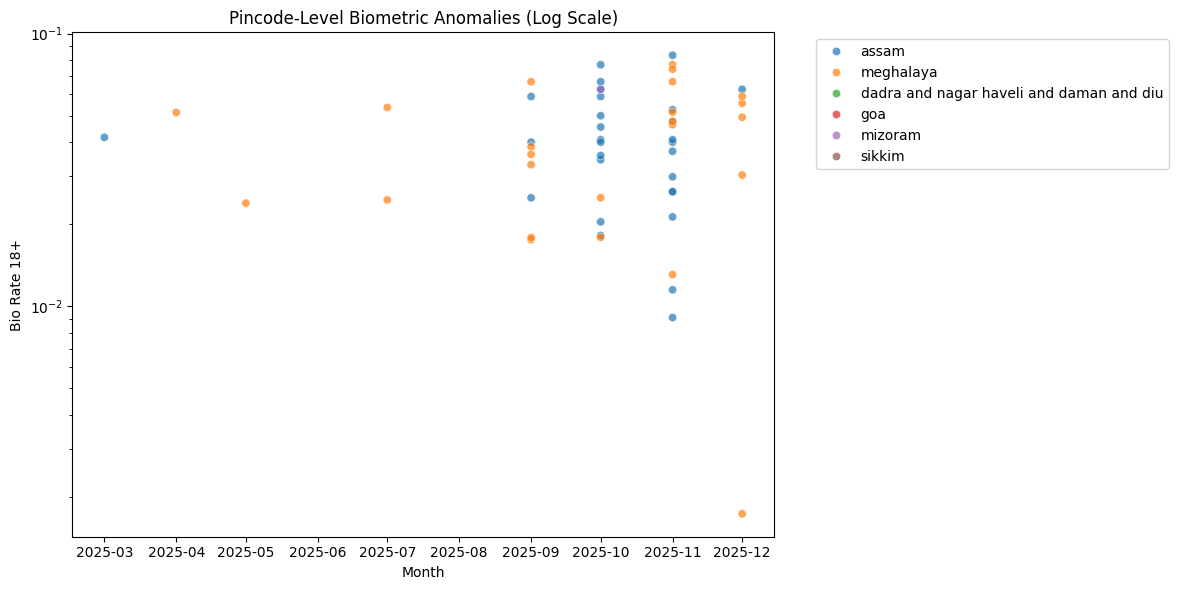

In [36]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=anomalies,
    x="month",
    y="bio_rate_18p",
    hue="state",
    alpha=0.7
)
plt.yscale("log")
plt.title("Pincode-Level Biometric Anomalies (Log Scale)")
plt.xlabel("Month")
plt.ylabel("Bio Rate 18+")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/pincode_anomalies_timeseries.png", dpi=300)
plt.show()


### Graph Interpretation: Pincode-Level Anomalies Time Series

**X-axis (Month)**: Temporal progression showing when anomalies occur
- Patterns reveal if problems are persistent or temporary
- Clustering in specific periods indicates systemic issues at certain times

**Y-axis (Bio Rate 18+, Log Scale)**: Severity of anomaly on logarithmic scale
- Points at y ≈ 0.1-1: Near-zero or extremely low completion rates (critical failures)
- Points at y ≈ 1-10: Low but measurable completion (below 5th percentile)
- Wide vertical spread: Indicates variability in severity across pincodes

**Color by State**: Each color represents one of the seven high-risk states
- Color clustering: Indicates state-specific vs. distributed problems
- If one color dominates: That state faces systemic challenges
- If colors mixed evenly: Problems are distributed across multiple states

**Key Insights**:
- **Horizontal bands**: Persistent anomalies in specific pincodes affecting multiple months
- **Scattered points**: Sporadic operational failures in individual pincodes
- **Temporal trends**: Upward slope suggests improving anomaly rate; downward slope indicates worsening conditions
- **Outliers**: Isolated very-low points represent the most critical individual pincode-month combinations

## 18. Extract and Save Critical Pincodes Table

Filter pincode-level summary to include only those with anomalies (zero months or low-rate months), sort by risk score, and save to CSV. Display top 20 for quick reference.

In [37]:
# Only keep pincodes with anomalies
anomalous_pincodes = pincode_summary[
    (pincode_summary["zero_count"] > 0) | (pincode_summary["anomaly_count"] > 0)
].copy()

# Sort by risk_score
anomalous_pincodes = anomalous_pincodes.sort_values(
    ["risk_score"], ascending=False
)

# Save
anomalous_pincodes.to_csv(f"{OUTPUT_DIR}/critical_pincodes.csv", index=False)

# Quick display
display(anomalous_pincodes.head(20))


,state,pincode,avg_bio_rate,anomaly_count,zero_count,months_observed,zero_ratio,anomaly_ratio,risk_score
265,assam,785013,0.000000,1,1,1,1.000000,1.000000,1.000000
473,dadra and nagar haveli and daman and diu,362520,0.000000,1,1,1,1.000000,1.000000,1.000000
586,meghalaya,794003,0.750000,1,1,2,0.500000,0.500000,0.514286
352,assam,786179,3.000000,1,1,2,0.500000,0.500000,0.450000
102,assam,781375,15.000000,1,1,2,0.500000,0.500000,0.412500
504,goa,403513,19.500000,1,1,2,0.500000,0.500000,0.409756
578,meghalaya,793123,0.400000,1,1,3,0.333333,0.333333,0.409524
458,assam,788734,20.500000,1,1,2,0.500000,0.500000,0.409302
257,assam,784527,38.500000,1,1,2,0.500000,0.500000,0.405063
573,meghalaya,793116,0.107453,1,1,4,0.250000,0.250000,0.380595


### Table Interpretation: Critical Pincodes Summary

**Column Explanations**:
- **state**: State/region of the pincode
- **pincode**: Postal code identifier (5-digit numeric code)
- **avg_bio_rate**: Average biometric completion rate across all observed months (higher = better)
- **anomaly_count**: Number of months where rate fell below 5th percentile threshold
- **zero_count**: Number of months with zero biometric collection
- **months_observed**: Total months in the analysis period for this pincode
- **zero_ratio**: Proportion of months with zero collection (zero_count / months_observed)
- **anomaly_ratio**: Proportion of months with anomalous low rates (anomaly_count / months_observed)
- **risk_score**: Composite score combining zero_ratio (50%), anomaly_ratio (30%), and low avg rate (20%)

**How to Use This Table**:
1. **Prioritization**: Pincodes at the top have highest risk_scores and need immediate intervention
2. **Intervention Strategy**: 
   - High zero_ratio → Requires infrastructure or basic operational setup
   - High anomaly_ratio → Requires capacity building and training
   - Low avg_bio_rate → Requires systemic restructuring
3. **Quick Screening**: Filter by zero_ratio > 0.5 to find pincodes with persistent complete failures
4. **Geographic Focus**: Group by state to plan state-level strategies

## 19. Extract and Save Critical Pincodes Table

Filter district-level summary to include only those with anomalies (zero months or low-rate months), sort by risk score, and save to CSV. Display top 20 for quick reference.

In [38]:
# Aggregate at district level
district_summary = (
    df.groupby(["state", "district"], as_index=False)
      .agg(
          avg_bio_rate=("bio_rate_18p", "mean"),
          anomaly_months=("low_anomaly", "sum"),
          zero_months=("zero_anomaly", "sum"),
          total_months=("bio_rate_18p", "count")
      )
)

# Compute ratios
district_summary["zero_ratio"] = district_summary["zero_months"] / district_summary["total_months"]
district_summary["anomaly_ratio"] = district_summary["anomaly_months"] / district_summary["total_months"]

# Only districts with anomalies
anomalous_districts = district_summary[
    (district_summary["zero_months"] > 0) | (district_summary["anomaly_months"] > 0)
].copy()

# Sort by anomaly severity
anomalous_districts = anomalous_districts.sort_values(
    ["zero_ratio", "anomaly_ratio"], ascending=False
)

# Save
anomalous_districts.to_csv(f"{OUTPUT_DIR}/critical_districts.csv", index=False)

# Quick display
display(anomalous_districts.head(20))


,state,district,avg_bio_rate,anomaly_months,zero_months,total_months,zero_ratio,anomaly_ratio
61,mizoram,Khawzawl,0.000000,2,2,2,1.000000,1.000000
24,assam,Majuli,2.665341,3,2,4,0.500000,0.750000
39,dadra and nagar haveli and daman and diu,Diu,2.000000,1,1,2,0.500000,0.500000
65,mizoram,Mamit,2.125000,2,2,4,0.500000,0.500000
76,sikkim,South Sikkim,5.305785,6,6,22,0.272727,0.272727
50,meghalaya,Jaintia Hills,0.017782,4,1,4,0.250000,1.000000
66,mizoram,Mammit,2.458333,1,1,4,0.250000,0.250000
0,assam,Bajali,0.350000,1,1,5,0.200000,0.200000
12,assam,Dima Hasao,0.700000,1,1,5,0.200000,0.200000
40,goa,Bardez,1.800000,2,2,10,0.200000,0.200000


### Table Interpretation: Critical Districts Summary

**Column Explanations**:
- **state**: State/region of the district
- **district**: District name
- **avg_bio_rate**: Average biometric completion rate across all observed months and pincodes in district
- **anomaly_months**: Total number of district-month combinations with rates below 5th percentile
- **zero_months**: Total number of district-month combinations with zero collection
- **total_months**: Total number of district-month observations in analysis
- **zero_ratio**: Proportion of months with zero collection (zero_months / total_months)
- **anomaly_ratio**: Proportion of months with anomalously low rates (anomaly_months / total_months)

**Key Insights from This View**:
- **District-level risks**: Helps identify whether problems are pincode-specific or district-wide
- **Zero_ratio > 0.3**: Indicates persistent district-level infrastructure or organizational challenges
- **Anomaly_ratio > 0.4**: Suggests widespread capacity or implementation issues across most pincodes
- **Low avg_bio_rate with high zero_ratio**: District lacks basic infrastructure for biometric collection
- **Low avg_bio_rate with high anomaly_ratio**: District has infrastructure but struggles with effective implementation

**Intervention Strategy by District Profile**:
1. **High zero_ratio**: Need to establish/rehabilitate infrastructure, provide equipment, assign personnel
2. **High anomaly_ratio**: Need training programs, process optimization, quality oversight
3. **Both high**: District requires comprehensive restructuring with both infrastructure and capacity building

## 20. Export Complete Analysis Datasets to CSV

Save all processed datasets to CSV files for archival, further analysis, and stakeholder sharing:
- **risk_states_pincode_level_data.csv**: Complete month-level pincode data with biometric rates and anomaly flags
- **risk_states_pincode_anomalies.csv**: Filtered dataset containing only anomalous records for investigation
- **risk_states_pincode_summary.csv**: Aggregated pincode-level metrics across all months

Print confirmation message upon successful export.

In [39]:
df.to_csv(f"{OUTPUT_DIR}/risk_states_pincode_level_data.csv", index=False)
anomalies.to_csv(f"{OUTPUT_DIR}/risk_states_pincode_anomalies.csv", index=False)
pincode_summary.to_csv(f"{OUTPUT_DIR}/risk_states_pincode_summary.csv", index=False)

print("Analysis complete. Outputs saved to:", OUTPUT_DIR)

Analysis complete. Outputs saved to: risk_state_pincode_analysis
